# Volume Sampling vs projection DPP for low rank approximation
## Introduction
#### In this notebook we compare the volume sampling and projection DPP for low rank approximation.
We recall the result proved in the article [DRVW]:\\
Let S be a random subset of k columns of X chosen with probability: $$P(S) = \frac{1}{Z_{k}} det(X_{.,S}^{T}X_{.,S})$$ with $$Z_{k} = \sum\limits_{S \subset [N], |S| = k} det(X_{.,S}^{T}X_{.,S})$$
Then
$$\begin{equation}
E(\| X - \pi_{X_{.,S}}(X) \|_{Fr}^{2}) \leq (k+1)\| X - \pi_{k}(X) \|_{Fr}^{2}
\end{equation}$$


We can prove that the volume sampling distribution is a mixture of projection DPPs distributions..., in particular one projection DPP distribution stands out for the problem of low rank approximation: ....\\
For the moment, there is no analytical expression for $$\begin{equation}
E(\| X - \pi_{X_{.,S}}(X) \|_{Fr}^{2}) 
\end{equation}$$ under the distribution of projection DPP.\\
However, we can calculate this quantity using simulation on some matrices representing cloud points with some specific geometric constraints.

Let $$X \in R^{n \times m}$$ a matrix representing a cloud of points.
We can write the SVD of $$X = UDV^{T}$$  
In this notebook we investigate the influence of some structures enforced to V and D on the expected error expressed above for different algorithms: Volume Sampling, Projection DPP and the deterministic algorithm.  
As for the Volume Sampling distribution, we can express the expected approximation error using only the elements of D. We can test this theoretical property in the next Numerical Study below. However, there is no closed formula (for the moment) for the expected approximation error under Projection DPP distribution. We will see in the Numerical Study section, that this value cannot depends only on the elements of D. 

#### References
[DRVW] Deshpande, Amit and Rademacher, Luis and Vempala, Santosh and Wang, Grant - Matrix Approximation and Projective Clustering via Volume Sampling 2006

[BoDr] Boutsidis, Christos and Drineas, Petros  - Deterministic and randomized column selection algorithms for matrices 2014

[] INDERJIT S. DHILLON , ROBERT W. HEATH JR., MA ́TYA ́S A. SUSTIK, AND
JOEL A. TROPP - GENERALIZED FINITE ALGORITHMS FOR CONSTRUCTING HERMITIAN MATRICES
WITH PRESCRIBED DIAGONAL AND SPECTRUM 2005

## I- Generating a cloud of points with geometric constraints
In this simulation we will enforce some structure on the matrix V for two values of the matrix D. While the matrix U will be choosen randomly.  
We want to investigate the influence of the profile of the norms of the V_k rows: the k-leverage scores. For this purpose we use an algorithm proposed in the article []: this algorithm outputs a ( dxk)  matrix Q with orthonormal columns and a prescribed profile of the norms of the rows. If we consider the Gram matrix H= QQ^{T}, this boils down to enforce the diagonal of H while keeping its spectrum containing k ones and d-k zeros.  
The algorithm proceed as following:
* Initialization of the matrix Q by the rectangular identity
* Apply a Givens Rotation (of dimension d) to the matrix Q: this step will enforce the norm of a row every iteration
* Outputs the resulting matrix when all the rows norms are enforced.


In [91]:
import numpy as np
import pandas as pd
from itertools import combinations
from scipy.stats import binom
import scipy.special
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, HTML
from FrameBuilder.eigenstepsbuilder import *
from decimal import *

### I-1- Givens Rotations generators
These functions generate a Givens rotation 

In [2]:
def t_func(q_i,q_j,q_ij,l_i,l_j): 
    # t in section 3.1 Dhillon (2005) 
    delta = np.power(q_ij,2)-(q_i-l_i)*(q_j-l_i)
    if delta<0:
        print(delta)
        print("error sqrt")
    t = q_ij - np.sqrt(delta) 
    t = t/(q_j-l_i)
    return t
     
def G_func(i,j,q_i,q_j,q_ij,l_i,l_j,N): 
    # Gitens Rotation 
    G=np.eye(N) 
    t = t_func(q_i,q_j,q_ij,l_i,l_j)
    c = 1/(np.sqrt(np.power(t,2)+1))
    s = t*c
    G[i,i]=c
    G[i,j]=s 
    G[j,i]= -s
    G[j,j]= c
    return G

The following function is an implementation of the algorithm [] figuring in the article [] to generate an orthogonal matrix with a prescribed profile of leverage scores.
In fact this is a simplification of the algorithm .....

In [3]:
class Data_Set_Generator:
    def __init__(self, N, d, nu, Sigma):
        self.N = N
        self.d = d
        self.nu = nu
        self.Sigma = Sigma
        self.mean = np.zeros(d)
        
    def multivariate_t_rvs(self):
        x = np.random.chisquare(self.nu, self.N)/self.nu
        z = np.random.multivariate_normal(self.mean,self.Sigma,(self.N,))
        return self.mean + z/np.sqrt(x)[:,None] 

In [72]:
def generate_orthonormal_matrix_with_leverage_scores_ES(N,d,lv_scores_vector,versions_number,nn_cardinal_list):

    lambda_vector = np.zeros((N))
    lambda_vector[0:d] = np.ones((d))

    #mu_vector = np.linspace(1, 0.1, num=N)
    #sum_mu_vector = np.sum(mu_vector)
    #mu_vector = d/sum_mu_vector*mu_vector
    Q = np.zeros((N,d))
    previous_Q = np.zeros((versions_number+1,N,d))
    #mu_vector = d/N*np.ones((N,1))
    E = np.zeros((N,N)) #(d,N)
    counter = 0
    for j in nn_cardinal_list:
        print("counter")
        print(counter)
        mu_vector = generate_leverage_scores_vector_with_dirichlet(N,d,j)
        print(np.sum(mu_vector))
        print(mu_vector)
        E_test = get_eigensteps_random(mu_vector,lambda_vector,N,d)
        E_ = np.zeros((d,N+1))
        for i in range(d):
            E_[i,1:N+1] = E_test[i,:] 
        F_test = get_F(d,N,np.asmatrix(E_),mu_vector)
        previous_Q[counter,:,:] = np.transpose(F_test)
        Q = np.transpose(F_test)
        counter = counter +1
    return Q,previous_Q

In [143]:
Q,previous_Q = generate_orthonormal_matrix_with_leverage_scores_ES(100,2,[],3,[20,10,10])

counter
0
2.0
[0.61426, 0.18506, 0.17432, 0.1239, 0.10059, 0.099121, 0.09021, 0.085205, 0.085083, 0.069824, 0.066772, 0.065308, 0.064514, 0.064392, 0.037811, 0.025101, 0.019394, 0.018295, 0.0084991, 0.0021992, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
counter


/Users/abelhadj/Desktop/FrameBuilder/FrameBuilder/eigenstepsbuilder.py:137: RuntimeWarning: invalid value encountered in sqrt
  v_n[v_n_index] = np.sqrt(-np.prod(nom_v_n)/np.prod(denom_v_n))
/Users/abelhadj/Desktop/FrameBuilder/FrameBuilder/eigenstepsbuilder.py:144: RuntimeWarning: divide by zero encountered in double_scalars
  w_n[w_n_index] = np.sqrt(np.prod(nom_w_n)/np.prod(denom_w_n))


1
2.0
[0.80859, 0.33569, 0.2688, 0.22998, 0.12646, 0.097595, 0.083008, 0.040588, 0.0085983, 0.0005002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
counter
2
2.0
[0.57861, 0.37891, 0.323, 0.22937, 0.20776, 0.1217, 0.076172, 0.040497, 0.028, 0.016098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [63]:
previous_Q

array([[[ 0.64216002,  0.        ],
        [-0.18802007, -0.53902147],
        [ 0.21753891,  0.50028943],
        ..., 
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.92100946,  0.        ],
        [ 0.07242599, -0.72642915],
        [-0.15342414, -0.60459993],
        ..., 
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.84549494,  0.        ],
        [-0.17900511,  0.67818971],
        [ 0.39118836,  0.38375836],
        ..., 
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 1.03134402,  0.        ],
        [ 0.        ,  0.5599646 ],
        [ 0.        ,  0.49710795],
        ..., 
        [        nan,         nan],
        [        nan,         nan],
        [        nan,         nan]],

       [[ 0.80850705,  0.        ],
        [ 0.21040674,  0.71491349],


In [141]:
def generate_leverage_scores_vector_with_dirichlet(d,k,nn_cardinal):
    getcontext().prec = 3
    mu_vector = np.float16(np.zeros((d,)))
    mu_vector_2 = np.float16(np.zeros((d,)))
    not_bounded = 1
    while(not_bounded == 1):
        mu_vector[0:nn_cardinal] = (k*np.random.dirichlet([1]*nn_cardinal, 1))[0]
        mu_vector = np.flip(np.sort(mu_vector),axis = 0)
        if max(mu_vector)<=1:
            not_bounded = 0
    for i in range(nn_cardinal):
        mu_vector_2[i] = round(mu_vector[i],4)
    mu_vector_2 = k*mu_vector_2/np.sum(mu_vector_2)
    return list(mu_vector_2)


In [142]:
l = generate_leverage_scores_vector_with_dirichlet(10,2,6)
print(l)
print(np.sum(l))

[0.66357, 0.54834, 0.36377, 0.22363, 0.18567, 0.015099, 0.0, 0.0, 0.0, 0.0]
2.0


In [4]:
def generate_orthonormal_matrix_with_leverage_scores(N,d,lv_scores_vector,versions_number,mode):
    #Transforming an idendity matrix to an orthogonal matrix with prescribed lengths
    Q = np.zeros((N,d))
    previous_Q = np.zeros((versions_number+1,N,d))
    versionning_period = (int)(N/versions_number)
    if mode == 'identity':
        for _ in range(0,d):
            Q[_,_] = 1
    if mode == 'spread':
        nu = 1
        Sigma = np.diag(np.ones(d))
        mean = np.zeros(d)
        x = np.random.chisquare(nu, N)/nu
        z = np.random.multivariate_normal(mean,Sigma,(N,))
        dataset = mean + z/np.sqrt(x)[:,None] 
        [Q,_,_] = np.linalg.svd(dataset,full_matrices=False)
        print(np.shape(Q))
    I_sorting =  list(reversed(np.argsort(lv_scores_vector)))
    
    lv_scores_vector = np.asarray(list(reversed(np.sort(lv_scores_vector))))
    initial_lv_scores_vector = np.diag(np.dot(Q,Q.T))
    I_initial_sorting = list(reversed(np.argsort(initial_lv_scores_vector)))
    initial_lv_scores_vector = np.asarray(list(reversed(np.sort(np.diag(np.dot(Q,Q.T))))))
    #initial_lv_scores_vector = 

    Q[I_initial_sorting,:] = Q
    print(lv_scores_vector)
    print(initial_lv_scores_vector)
    delta_lv_scores_vector = lv_scores_vector - initial_lv_scores_vector
    print(delta_lv_scores_vector)
    min_index = next((i for i, x in enumerate(delta_lv_scores_vector) if x>0), None)
    i = min_index-1
    j = min_index
    print(i)
    print(j)
    #if mode == 'identity':
    #    i = d-1
    #    j = d
    #if mode == 'spread':
    #    i = d-2
    #    j = d-1
    v_counter =0
    for t in range(N-1):
        #print(i)
        #print(j)
        delta_i = np.abs(lv_scores_vector[i] - np.power(np.linalg.norm(Q[i,:]),2))
        delta_j = np.abs(lv_scores_vector[j] - np.power(np.linalg.norm(Q[j,:]),2))
        q_i = np.power(np.linalg.norm(Q[i,:]),2)
        q_j = np.power(np.linalg.norm(Q[j,:]),2)
        q_ij = np.dot(Q[i,:],Q[j,:].T)
        l_i = lv_scores_vector[i]
        l_j = lv_scores_vector[j]
        G = np.eye(N)
        if t%versionning_period ==0:
            previous_Q[v_counter,:,:] = Q
            v_counter = v_counter +1
        if delta_i <= delta_j:
            l_k = q_i + q_j -l_i
            G = G_func(i,j,q_i,q_j,q_ij,l_i,l_k,N)
            Q = np.dot(G,Q)
            i = i-1
        else:
            l_k = q_i + q_j -l_j
            G = G_func(i,j,q_j,q_i,q_ij,l_j,l_k,N)
            Q = np.dot(G,Q)
            j = j+1
    previous_Q[versions_number,:,:] = Q
    return Q,previous_Q

The following function allows to estimate the leverage scores for an orthogonal matrix Q: the function calculates the diagonoal of the matrix $$Q Q^{T}$$

In [5]:
def estimate_leverage_scores_from_orthogonal_matrix(Q):
    [N,_] = np.shape(Q)
    lv_scores_vector = np.zeros((N,1))
    lv_scores_vector = np.diag(np.dot(Q,np.transpose(Q)))
    lv_scores_vector = np.asarray(list(reversed(np.sort(lv_scores_vector))))
    return lv_scores_vector
def estimate_sum_first_k_leverage_scores(Q,k):
    lv_scores_vector = estimate_leverage_scores_from_orthogonal_matrix(Q)
    res = np.sum(lv_scores_vector[0:k])
    return res

## I-2- Extending the orthogonal matrices

For the task of low rank approximation, we have seen that only the information contained in the first right k eigenvectors of the matrix X are relevant. In the previous step we build only the first right k eigenvectors but we still need to complete these orthogonal matrices with d-k columns. We proceed as following:
Generate a random vector (Nx1) using independent standard gaussian variables,
Project this vector in the orthogonal of the span of Q
Normalize the obtained vector after the projection
Extend the matrix Q
Note that this procedure is not the unique way to extend the matrix Q to an orthogonal (Nxd) matrix.

In [6]:
def extend_orthogonal_matrix(Q,d_target):
    [N,d] = np.shape(Q)
    Q_target = np.zeros((N,d))
    Q_target = Q
    delta = d_target - d
    for t in range(delta):
        Q_test = np.random.normal(0, 1, N)
        for _ in range(d):
            Q_test = Q_test - np.dot(Q_test,Q[:,_])*Q[:,_]
        Q_test = Q_test/np.linalg.norm(Q_test)
        Q_test = Q_test.reshape(N,1)
        Q_target = np.append(Q_target,Q_test,1)
    return Q_target

#extended_Q = extend_orthogonal_matrix(Q,r)

## I-3 - Constructing a dataset for every extended orthogonal matrix 
The previous step allow us to build (N x d) orthogonal matrices such that the extracted (N x k) matrix have a prescribed profile of leverage scores.
Now we construct a cloud of point by assigning a covariance matrix D and a matrix V

In [7]:
def contruct_dataset_from_orthogonal_matrix(multi_Q,N,target_d,cov,mean,versions_number):
    multi_X = np.zeros((versions_number+1,N,real_dim))
    for t in range(versions_number+1):
        test_X = np.random.multivariate_normal(mean, cov, N)
        [U,_,_] = np.linalg.svd(test_X, full_matrices=False)
        Q_test = extend_orthogonal_matrix(multi_Q[t,:,:],target_d)
        multi_X[t,:,:] = np.dot(np.dot(Q_test,cov),U.T).T
    return multi_X



## II- Volume sampling vs Projection DPP for low rank approximation
These functions allow to quantify the approximation error:
* approximation_error_function_fro calculate the ratio of the approximation error of a subset of columns to the optimal approximatione error given by the first k left eigenvectors of the matrix X
* expected_approximation_error_for_sampling_scheme calculate the expected value of the ratio of the approximatione error under some sampling distribution

In [8]:
def approximation_error_function_fro(Sigma,k,X,X_S):
    ## Sigma is the spectrum of the matrix X: we need to calculate the optimal approximation error given by the PCA
    ## k is the rank of the approximation
    ## X is the initial matrix
    ## X_S is the subset of columns of the matrix X for witch we calculate the approximation error ratio
    d = list(Sigma.shape)[0] # the dimension of the matrix X
    Sigma = np.multiply(Sigma,Sigma)  # Sigma power 2 -> we are intersted in the approximation error square
    sigma_S_temp = np.linalg.inv(np.dot(X_S.T,X_S))  # just a temporary matrix to construct the projection matrix
    projection_S = np.dot(np.dot(X_S,sigma_S_temp),X_S.T) # the projection matrix P_S
    res_X = X - np.dot(projection_S,X) # The projection of the matrix X in the orthogonal of S
    approximation_error_ratio = np.power(np.linalg.norm(res_X,'fro'),2)/np.sum(Sigma[k:d])
    # Calculate the apparoximation error ratio
    return approximation_error_ratio

In [9]:
def approximation_error_function_spectral(Sigma,k,X,X_S):
    ## Sigma is the spectrum of the matrix X: we need to calculate the optimal approximation error given by the PCA
    ## k is the rank of the approximation
    ## X is the initial matrix
    ## X_S is the subset of columns of the matrix X for witch we calculate the approximation error ratio
    d = list(Sigma.shape)[0] # the dimension of the matrix X
    Sigma = np.multiply(Sigma,Sigma)  # Sigma power 2 -> we are intersted in the approximation error square
    sigma_S_temp = np.linalg.inv(np.dot(X_S.T,X_S))  # just a temporary matrix to construct the projection matrix
    projection_S = np.dot(np.dot(X_S,sigma_S_temp),X_S.T) # the projection matrix P_S
    res_X = X - np.dot(projection_S,X) # The projection of the matrix X in the orthogonal of S
    approximation_error_ratio = np.power(np.linalg.norm(res_X,ord = 2),2)/np.sum(Sigma[k:k+1])
    # Calculate the apparoximation error ratio
    return approximation_error_ratio

In [10]:
def upper_bound_error_function_for_projection_DPP(k,X,X_S):
    ## Sigma is the spectrum of the matrix X: we need to calculate the optimal approximation error given by the PCA
    ## k is the rank of the approximation
    ## X is the initial matrix
    ## X_S is the subset of columns of the matrix X for witch we calculate the approximation error ratio
    _,sigma_S_temp,_ = np.linalg.svd(X_S, full_matrices=False)  # just a temporary matrix to construct the projection matrix
    trunc_product = np.power(np.prod(sigma_S_temp[0:k-1]),2)
    if np.power(np.prod(sigma_S_temp[0:k]),2) == 0:
        trunc_product = 0
    # Calculate the apparoximation error ratio
    return trunc_product

In [11]:
def tight_upper_bound_error_function_fro(k,X,X_S,V_k,V_k_S):
    ## Sigma is the spectrum of the matrix X: we need to calculate the optimal approximation error given by the PCA
    ## k is the rank of the approximation
    ## X is the initial matrix
    ## X_S is the subset of columns of the matrix X for witch we calculate the approximation error ratio
    _,Sigma,_ = np.linalg.svd(X, full_matrices=False)
    d = list(Sigma.shape)[0]
    Sigma = np.multiply(Sigma,Sigma)
    if np.linalg.matrix_rank(V_k_S,0.000001) == k:
        temp_T = np.dot(np.linalg.inv(V_k_S),V_k)
        temp_matrix = X - np.dot(X_S,temp_T)
    
        return np.power(np.linalg.norm(temp_matrix,'fro'),2)/np.sum(Sigma[k:d])
    else:
        return 0

In [132]:
def get_the_matrix_sum_T_S(k,d,V_k,V_d_k):
    ## Sigma is the spectrum of the matrix X: we need to calculate the optimal approximation error given by the PCA
    ## k is the rank of the approximation
    ## X is the initial matrix
    ## X_S is the subset of columns of the matrix X for witch we calculate the approximation error ratio
    #Sigma = np.multiply(Sigma,Sigma)
    #matrices_array = [ np.dot(V_d_k[:,list(comb)],np.dot(np.dot(np.linalg.inv(V_k[:,list(comb)]),np.linalg.inv(V_k[:,list(comb)]))),np.transpose(V_d_k[:,list(comb)])) for comb in combinations(range(d),k) if np.linalg.matrix_rank(V_k[:,list(comb)],0.000001) == k]
    T = np.zeros((d-k,d-k))
    for comb in combinations(range(d),k):
        if np.linalg.matrix_rank(V_k[:,list(comb)],0.0000000001) == k: 
            V_k_S_inv = np.linalg.inv(V_k[:,list(comb)])
            V_d_k_S = V_d_k[:,list(comb)]
            V_k_S_inv_2 = np.transpose(np.dot(V_k_S_inv,np.transpose(V_k_S_inv)))
            #T = np.dot(np.dot(np.dot(V_d_k_S,np.dot(V_k_S_inv,np.transpose(V_k_S_inv)))),np.transpose(V_d_k_S)) + T
            T = np.power(np.linalg.det(V_k[:,list(comb)]),2)*np.dot(V_d_k_S,np.dot(V_k_S_inv_2,np.transpose(V_d_k_S))) +T
    return T

In [12]:
def tight_approximation_error_fro_for_sampling_scheme(X,U,k,N):
    ## X is the matrix X :)
    ## U is the matrix used in the sampling: we sample propotional to the volume of UU^{T}_{S,S}: 
    ## we are not sampling but we need the weigth to estimate the expected error
    ## k is the rank of the approximation
    ## N is the number of columns (to be changed to avoid confusion with the number of points)
    _,Sigma,V = np.linalg.svd(X, full_matrices=False)
    V_k = V[0:k,:]
    ## Estimating the spectrum of X -> needed in approximation_error_function_fro
    volumes_array = [np.abs(np.linalg.det(np.dot(U[:,list(comb)].T,U[:,list(comb)]))) for comb in combinations(range(N),k)]
    ## Construct the array of weights: the volumes of UU^{T}_{S,S}
    volumes_array_sum = np.sum(volumes_array)
    ## The normalization constant
    volumes_array = volumes_array/volumes_array_sum
    ## The weigths normalized
    approximation_error_array = [tight_upper_bound_error_function_fro(k,X,X[:,list(comb)],V_k,V_k[:,list(comb)]) for comb in combinations(range(N),k)]
    ## Calculating the approximation error for every k-tuple
    expected_value = np.dot(approximation_error_array,volumes_array)
    ## The expected value of the approximatione error is just the dot product of the two arrays above
    return expected_value

In [13]:
def expected_approximation_error_fro_for_sampling_scheme(X,U,k,N):
    ## X is the matrix X :)
    ## U is the matrix used in the sampling: we sample propotional to the volume of UU^{T}_{S,S}: 
    ## we are not sampling but we need the weigth to estimate the expected error
    ## k is the rank of the approximation
    ## N is the number of columns (to be changed to avoid confusion with the number of points)
    _,Sigma,_ = np.linalg.svd(X, full_matrices=False)
    ## Estimating the spectrum of X -> needed in approximation_error_function_fro
    volumes_array = [np.abs(np.linalg.det(np.dot(U[:,list(comb)].T,U[:,list(comb)]))) for comb in combinations(range(N),k)]
    ## Construct the array of weights: the volumes of UU^{T}_{S,S}
    volumes_array_sum = np.sum(volumes_array)
    ## The normalization constant
    volumes_array = volumes_array/volumes_array_sum
    ## The weigths normalized
    approximation_error_array = [approximation_error_function_fro(Sigma,k,X,X[:,list(comb)]) for comb in combinations(range(N),k)]
    ## Calculating the approximation error for every k-tuple
    expected_value = np.dot(approximation_error_array,volumes_array)
    ## The expected value of the approximatione error is just the dot product of the two arrays above
    return expected_value

In [14]:
def expected_approximation_error_spectral_for_sampling_scheme(X,U,k,N):
    ## X is the matrix X :)
    ## U is the matrix used in the sampling: we sample propotional to the volume of UU^{T}_{S,S}: 
    ## we are not sampling but we need the weigth to estimate the expected error
    ## k is the rank of the approximation
    ## N is the number of columns (to be changed to avoid confusion with the number of points)
    _,Sigma,_ = np.linalg.svd(X, full_matrices=False)
    ## Estimating the spectrum of X -> needed in approximation_error_function_fro
    volumes_array = [np.abs(np.linalg.det(np.dot(U[:,list(comb)].T,U[:,list(comb)]))) for comb in combinations(range(N),k)]
    ## Construct the array of weights: the volumes of UU^{T}_{S,S}
    volumes_array_sum = np.sum(volumes_array)
    ## The normalization constant
    volumes_array = volumes_array/volumes_array_sum
    ## The weigths normalized
    approximation_error_array = [approximation_error_function_spectral(Sigma,k,X,X[:,list(comb)]) for comb in combinations(range(N),k)]
    ## Calculating the approximation error for every k-tuple
    expected_value = np.dot(approximation_error_array,volumes_array)
    ## The expected value of the approximatione error is just the dot product of the two arrays above
    return expected_value

In [15]:
def expected_upper_bound_for_projection_DPP(X,U,k,N):
    ## X is the matrix X :)
    ## U is the matrix used in the sampling: we sample propotional to the volume of UU^{T}_{S,S}: 
    ## we are not sampling but we need the weigth to estimate the expected error
    ## k is the rank of the approximation
    ## N is the number of columns (to be changed to avoid confusion with the number of points)

    approximation_error_array = [upper_bound_error_function_for_projection_DPP(k,X,U[:,list(comb)]) for comb in combinations(range(N),k)]
    ## Calculating the approximation error for every k-tuple
    
    ## The expected value of the approximatione error is just the dot product of the two arrays above
    #return expected_value
    return np.sum(approximation_error_array)

## III - Numerical analysis

In this section we use the functions developed previously to investigate the influence of two parameters: the spectrum of X and the k-leverage scores.  
For this purpose, we assemble these functionalities in a class allowing fast numerical experiments.

In [159]:
class Numrerical_Analysis_DPP: 
    def __init__(self,N,real_dim,r,k,versions_number,mean,cov,lv_scores):
        self.N = N
        self.real_dim = real_dim
        self.r = r
        self.k = k
        self.versions_number = versions_number
        self.mean = mean
        self.cov = cov
        self.lv_scores = lv_scores
        self.Q = np.zeros((real_dim,k))
        self.multi_Q = np.zeros((self.versions_number+1,real_dim,k))
        self.X = np.zeros((N,real_dim))
        self.multi_X = np.zeros((self.versions_number+1,N,real_dim))
        [self.Q,self.multi_Q] = generate_orthonormal_matrix_with_leverage_scores(real_dim,k,lv_scores,versions_number,'identity')
        self.multi_X = contruct_dataset_from_orthogonal_matrix(self.multi_Q,self.N,self.real_dim,self.cov,self.mean,self.versions_number)
    def contruct_dataset_from_orthogonal_matrix_4(self,multi_Q,N,target_d,cov,mean,versions_number):
        test_multi_X = np.zeros((self.versions_number+1,N,real_dim))
        for t in range(self.versions_number+1):
            test_X = np.random.multivariate_normal(mean, cov, N)
            [U,_,_] = np.linalg.svd(test_X, full_matrices=False)
            Q_test = extend_orthogonal_matrix(self.multi_Q[t,:,:],target_d)
            test_multi_X[t,:,:] = np.dot(np.dot(Q_test,cov),U.T).T
        return test_multi_X
    def get_expected_error_fro_for_volume_sampling(self):
        ## Calculate the expected error ratio for the Volume Sampling distribution for every dataset
        res_list = np.zeros(self.versions_number+1)
        for t in range(self.versions_number+1):
            test_X = self.multi_X[t,:,:]
            res_list[t] = expected_approximation_error_fro_for_sampling_scheme(test_X,test_X,self.k,self.real_dim)
        return res_list
    def get_tight_upper_bound_error_fro_for_projection_DPP(self):
        res_list = np.zeros(self.versions_number+1)
        for t in range(self.versions_number+1):
            test_X = self.multi_X[t,:,:]
            test_U = self.multi_Q[t,:,:].T
            res_list[t] = tight_approximation_error_fro_for_sampling_scheme(test_X,test_U,self.k,self.real_dim)
        return res_list
    def get_max_diag_sum_T_matrices(self):
        res_list = np.zeros((self.versions_number+1))
        for t in range(self.versions_number+1):
            test_X = self.multi_X[t,:,:]
            _,_,test_V = np.linalg.svd(test_X, full_matrices=False)
            test_V_k = test_V[0:self.k,:]
            test_V_d_k = test_V[self.k:self.real_dim,:]
            res_list[t] = 1+np.max(np.diag(get_the_matrix_sum_T_S(self.k,self.real_dim,test_V_k,test_V_d_k)))
        return res_list
    def get_max_spectrum_sum_T_matrices(self):
        res_list = np.zeros((self.versions_number+1))
        for t in range(self.versions_number+1):
            test_X = self.multi_X[t,:,:]
            _,_,test_V = np.linalg.svd(test_X, full_matrices=False)
            test_V_k = test_V[0:self.k,:]
            test_V_d_k = test_V[self.k:self.real_dim,:]
            res_list[t] = 1+np.max(np.diag(get_the_matrix_sum_T_S(self.k,self.real_dim,test_V_k,test_V_d_k)))
        return res_list
    def get_expected_error_fro_for_projection_DPP(self):
        ## Calculate the expected error ratio for the Projection DPP distribution for every dataset
        res_list = np.zeros(self.versions_number+1)
        for t in range(self.versions_number+1):
            test_X = self.multi_X[t,:,:]
            test_U = self.multi_Q[t,:,:].T
            res_list[t] = expected_approximation_error_fro_for_sampling_scheme(test_X,test_U,self.k,self.real_dim)
        return res_list   
    def get_expected_error_spectral_for_volume_sampling(self):
        ## Calculate the expected error ratio for the Volume Sampling distribution for every dataset
        res_list = np.zeros(self.versions_number+1)
        for t in range(self.versions_number+1):
            test_X = self.multi_X[t,:,:]
            res_list[t] = expected_approximation_error_spectral_for_sampling_scheme(test_X,test_X,self.k,self.real_dim)
        return res_list
    def get_expected_error_spectral_for_projection_DPP(self):
        ## Calculate the expected error ratio for the Projection DPP distribution for every dataset
        res_list = np.zeros(self.versions_number+1)
        for t in range(self.versions_number+1):
            test_X = self.multi_X[t,:,:]
            test_U = self.multi_Q[t,:,:].T
            res_list[t] = expected_approximation_error_spectral_for_sampling_scheme(test_X,test_U,self.k,self.real_dim)
        return res_list  
    def get_upper_bound_error_for_projection_DPP(self):
        ## Calculate the expected error ratio for the Projection DPP distribution for every dataset
        #res_list = np.zeros(self.versions_number+1)
        res_list = []
        for t in range(self.versions_number+1):
            test_X = self.multi_X[t,:,:]
            test_U = self.multi_Q[t,:,:].T
            #res_list[t] = expected_upper_bound_for_projection_DPP(test_X,test_U,self.k,self.real_dim)
            res_list.append( expected_upper_bound_for_projection_DPP(test_X,test_U,self.k,self.real_dim))
        return res_list  
    def get_error_fro_for_deterministic_selection(self):
        ## Calculate the error ratio for the k-tuple selected by the deterministic algorithm for every dataset
        res_list = np.zeros(self.versions_number+1)
        for t in range(self.versions_number+1):
            test_X = self.multi_X[t,:,:]
            test_U = self.multi_Q[t,:,:].T
            lv_scores_vector = np.diag(np.dot(np.transpose(test_U),test_U))
            test_I_k = list(np.argsort(lv_scores_vector)[self.real_dim-self.k:self.real_dim])
            _,test_Sigma,_ = np.linalg.svd(test_X, full_matrices=False)
            res_list[t] = approximation_error_function_fro(test_Sigma,self.k,test_X,test_X[:,test_I_k])
            #res_list.append(test_I_k)
        return res_list   
    def get_error_spectral_for_deterministic_selection(self):
        ## Calculate the error ratio for the k-tuple selected by the deterministic algorithm for every dataset
        res_list = np.zeros(self.versions_number+1)
        for t in range(self.versions_number+1):
            test_X = self.multi_X[t,:,:]
            test_U = self.multi_Q[t,:,:].T
            lv_scores_vector = np.diag(np.dot(np.transpose(test_U),test_U))
            test_I_k = list(np.argsort(lv_scores_vector)[self.real_dim-self.k:self.real_dim])
            _,test_Sigma,_ = np.linalg.svd(test_X, full_matrices=False)
            res_list[t] = approximation_error_function_spectral(test_Sigma,self.k,test_X,test_X[:,test_I_k])
            #res_list.append(test_I_k)
        return res_list 
    def get_sum_k_leverage_scores(self):
        ## A function that calculate the k-sum: the sum of the first k k-leverage scores. It is a measure of the concentration of V_k
        ## This is done for every dataset
        res_list = np.zeros(self.versions_number+1)
        for t in range(self.versions_number+1):
            res_list[t] = estimate_sum_first_k_leverage_scores(self.multi_Q[t,:,:],self.k)
        return res_list
    def get_deterministic_upper_bound(self):
        ## A function that calculate the theoretical upper bound for the deterministic algorithm for every dataset
        res_list = np.zeros(self.versions_number+1)
        for t in range(self.versions_number+1):
            res_list[t] = 1/(1+estimate_sum_first_k_leverage_scores(self.multi_Q[t,:,:],self.k)-self.k)
        return res_list
    def get_alpha_sum_k_leverage_scores(self,alpha):
        ## A function that calculate the theoretical upper bound for the deterministic algorithm for every dataset
        res_list = np.zeros(self.versions_number+1)
        #k_l = self.get_sum_k_leverage_scores()
        for t in range(self.versions_number+1):
            k_l = estimate_leverage_scores_from_orthogonal_matrix(self.multi_Q[t,:,:])[0:k]
            func_k = np.power(np.linspace(1, k, num=k),alpha)
            res_list[t] = np.dot(func_k,k_l)
        return res_list

### III- 0 Parameters of the simultations

In [170]:
## The dimensions of the design matrix X
N = 100       # The number of observations in the dataset
real_dim = 20 # The dimension of the dataset
## The low rank paramters
k = 4         # The rank of the low rank approximation 
## The covariance matrix parameters
r = 6         # Just a parameter to control the number of non trivial singular values in the covariance matrix
mean = np.zeros((real_dim))    # The mean vector useful to generate U (X = UDV^T)
cov_test = 0.1*np.ones((real_dim-r))  # The "trivial" singular values in the covariance matrix (there are real_dim-r)
## The paramters of the matrix V
versions_number = 5 # The number of orthogonal matrices (and therefor datasets) (-1) generated by the algorithm above
lv_scores_vector = k/real_dim*np.ones(real_dim)  # The vector of leverage scores (the last one)

### III-1 The influence of the spectrum

In this subsection we compare the Volume Sampling distribution to the projection DPP distribution and the deterministic algorithm of []  for different profiles of the spectrum with k-leverage scores profile fixed. In other words, if we note $$X = UDV^{T}$$ We keep V_{k} constant and we investigate the effect of D.

#### III-1-1 The case of a non-projection spectrum
We mean by a projection spectrum matrix, a matrix with equal the first k singular values.
We observe that the two distributions are very similar.... \todo{reword}

In [179]:
cov_1 = np.diag(np.concatenate(([100,100,100,100,5,5],cov_test)))
NAL_1 = Numrerical_Analysis_DPP(N,real_dim,r,k,versions_number,mean,cov_1,lv_scores_vector)


projection_DPP_res_fro_1 = NAL_1.get_expected_error_fro_for_projection_DPP()
volume_sampling_res_fro_1 = NAL_1.get_expected_error_fro_for_volume_sampling()
deterministic_selection_res_fro_1 = NAL_1.get_error_fro_for_deterministic_selection()
projection_DPP_res_spectral_1 = NAL_1.get_expected_error_spectral_for_projection_DPP()
volume_sampling_res_spectral_1 = NAL_1.get_expected_error_spectral_for_volume_sampling()
deterministic_selection_res_spectral_1 = NAL_1.get_error_spectral_for_deterministic_selection()

upper_tight_bound_projection_DPP_res_fro_1 = NAL_1.get_tight_upper_bound_error_fro_for_projection_DPP()

alpha_sum_res_1 = NAL_1.get_alpha_sum_k_leverage_scores(1)


sum_U_res_1 = NAL_1.get_sum_k_leverage_scores()
deterministic_upper_bound_res_1 = NAL_1.get_deterministic_upper_bound()

expected_upper_bound_res_1 = NAL_1.get_upper_bound_error_for_projection_DPP()
multi_Q_1 = NAL_1.multi_Q[1,:,:].T


[ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
  0.2  0.2  0.2  0.2  0.2]
[ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[-0.8 -0.8 -0.8 -0.8  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
  0.2  0.2  0.2  0.2  0.2]
3
4


In [180]:

print(k*(real_dim-k+1))
sum_T_matrices =  NAL_1.get_sum_T_matrices()

68


In [162]:
sum_T_matrices[2]

1.7359363541812884

In [183]:
pd_1 = pd.DataFrame(
    {'k-sum (ratio)': sum_U_res_1/k,
     'alpha k-sum': alpha_sum_res_1,
     'Expected Upper Bound for Projection DPP': expected_upper_bound_res_1,
     'Volume Sampling(Fro)': volume_sampling_res_fro_1,
     'Projection DPP(Fro)': projection_DPP_res_fro_1,
     'Very sharp approximation of Projection DPP(Fro)': upper_tight_bound_projection_DPP_res_fro_1,
     '1+Largest eigenvalue of sum_T': sum_T_matrices,
     'Deterministic Algorithm(Fro)': deterministic_selection_res_fro_1,
     'Volume Sampling(Spectral)': volume_sampling_res_spectral_1,
     'Projection DPP(Spectral)': projection_DPP_res_spectral_1,
     'Deterministic Algorithm(Spectral)': deterministic_selection_res_spectral_1,
     'Deterministic Upper Bound': deterministic_upper_bound_res_1
    })
pd_1 = pd_1[['k-sum (ratio)', 'alpha k-sum','Expected Upper Bound for Projection DPP','Volume Sampling(Fro)','Projection DPP(Fro)','Very sharp approximation of Projection DPP(Fro)','1+Largest eigenvalue of sum_T','Deterministic Algorithm(Fro)','Volume Sampling(Spectral)','Projection DPP(Spectral)','Deterministic Algorithm(Spectral)','Deterministic Upper Bound']]

In [184]:
pd_1

,k-sum (ratio),alpha k-sum,Expected Upper Bound for Projection DPP,Volume Sampling(Fro),Projection DPP(Fro),Very sharp approximation of Projection DPP(Fro),1+Largest eigenvalue of sum_T,Deterministic Algorithm(Fro),Volume Sampling(Spectral),Projection DPP(Spectral),Deterministic Algorithm(Spectral),Deterministic Upper Bound
0,1.00,10.0,1.000,4.926202,1.000000,1.000000,1.000000,1.000000,8.803169,1.000000,1.000000,1.000000
1,0.80,6.8,5.000,4.923115,1.136374,1.136871,1.663247,1.473758,6.653100,1.068493,1.286192,5.000000
2,0.65,5.0,16.880,4.921685,1.551058,1.554745,1.825671,1.294846,6.336934,1.625205,1.322935,-2.500000
3,0.50,3.6,26.936,4.925579,1.699969,1.703821,2.226536,1.836078,7.423669,1.861901,2.355279,-1.000000
4,0.35,2.6,36.256,4.926191,1.841557,1.847162,2.555151,1.112807,8.353569,2.341118,1.195264,-0.625000
5,0.20,2.0,44.296,4.926193,1.993425,2.000000,2.455843,1.417632,8.202907,2.472186,1.734757,-0.454545


#### Observations:
* The expected error is always smaller under the Projection DPP distribution compared to the Volume Sampling distribution.
* The expected error for the Volume Sampling distribution is constant for a contant D
* However the expected error for the Projection DPP distribution depends on the k-sum
* For X_0 and X_1, the profile of the k-leverage scores are highly concentrated (k-sum > k-1) thus epsilon is smaller than 1, in this regime the determinstic algorithm have the lower approximation error and it performs better than expected (the theoretical bound is 1/(1-epsilon).
* However, for the other datasets, the (k-sum < k-1) thus epsilon >1 and the deterministic algorithm have no guarantee in this regime: we observe that the approximation error for the deterministic algorithm can be very high in this regime.

#### Recall:
We recall here some geometrical properties of the matrices $$X_i$$
$$X_i = UD_{j}V_{i}$$
Where for every i, the first k columns of $$V_{i}$$ are the $$Q_{i}$$ while the other columns are gernerated randomly

In [22]:
previous_Q = NAL_1.multi_Q
lv_0 = estimate_leverage_scores_from_orthogonal_matrix(previous_Q[0,:,:])
lv_1 = estimate_leverage_scores_from_orthogonal_matrix(previous_Q[1,:,:])
lv_2 = estimate_leverage_scores_from_orthogonal_matrix(previous_Q[2,:,:])
lv_3 = estimate_leverage_scores_from_orthogonal_matrix(previous_Q[3,:,:])
lv_4 = estimate_leverage_scores_from_orthogonal_matrix(previous_Q[4,:,:])
lv_5 = estimate_leverage_scores_from_orthogonal_matrix(previous_Q[5,:,:])
index_list = list(range(real_dim))

In this example the objective is Q and the initialization is Q_0 (the rectangular identity)
We have with respect to the Schur-order (or the majorization):
$$Q = Q_5 \prec_{S} Q_4 \prec_{S} Q_3 \prec_{S} Q_2 \prec_{S} Q_1 \prec_{S} Q_0 $$

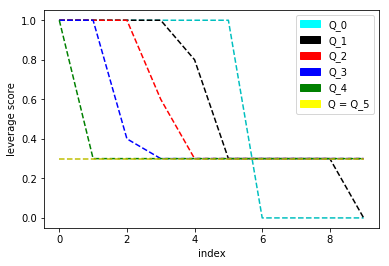

In [23]:
plt.plot(index_list[0:10], lv_0[0:10], 'c--',index_list[0:10], lv_1[0:10], 'k--', index_list[0:10], lv_2[0:10], 'r--', index_list[0:10], lv_3[0:10], 'b--',index_list[0:10], lv_4[0:10], 'g--',index_list[0:10], lv_5[0:10], 'y--')
plt.xlabel('index')
plt.ylabel('leverage score')
cyan_patch = mpatches.Patch(color='cyan', label='Q_0')
black_patch = mpatches.Patch(color='black', label='Q_1')
red_patch = mpatches.Patch(color='red', label='Q_2')
blue_patch = mpatches.Patch(color='blue', label='Q_3')
green_patch = mpatches.Patch(color='green', label='Q_4')
yellow_patch = mpatches.Patch(color='yellow', label='Q = Q_5')
plt.legend(handles=[cyan_patch,black_patch,red_patch,blue_patch,green_patch,yellow_patch])

plt.show()

#### III-1-2 The case of a projection spectrum
We mean by a projection spectrum matrix, a matrix with equal the first k singular values.
We observe that the two distributions are very similar.... \todo{reword}

In [24]:
cov_2 = np.diag(np.concatenate(([1000,1000,1000,1,0.1],cov_test)))
NAL_2 = Numrerical_Analysis_DPP(N,real_dim,r,k,versions_number,mean,cov_2,lv_scores_vector)
projection_DPP_res_2 = NAL_2.get_expected_error_for_projection_DPP()
volume_sampling_res_2 = NAL_2.get_expected_error_for_volume_sampling()
deterministic_selection_res_2 = NAL_1.get_error_for_deterministic_selection()
sum_U_res_2 = NAL_2.get_sum_k_leverage_scores()
deterministic_upper_bound_res_2 = NAL_2.get_deterministic_upper_bound()

results = [["Dataset","Using Volume Sampling","Using Projection DPP","k-sum","1/(1-epsilon)","Using Deterministic Algorithm"],["X_0",volume_sampling_res_2[0],projection_DPP_res_2[0],sum_U_res_2[0],deterministic_upper_bound_res_2[0],deterministic_selection_res_2[0]],["X_1",volume_sampling_res_2[1],projection_DPP_res_2[1],sum_U_res_2[1],deterministic_upper_bound_res_2[1],deterministic_selection_res_2[1]],
          ["X_2",volume_sampling_res_2[2],projection_DPP_res_2[2],sum_U_res_2[2],deterministic_upper_bound_res_2[2],deterministic_selection_res_2[2]],["X_3",volume_sampling_res_2[3],projection_DPP_res_2[3],sum_U_res_2[3],deterministic_upper_bound_res_2[3],deterministic_selection_res_2[3]],["X_4",volume_sampling_res_2[4],projection_DPP_res_2[4],sum_U_res_2[4],deterministic_upper_bound_res_2[4],deterministic_selection_res_2[4]],["X_5",volume_sampling_res_2[5],projection_DPP_res_2[5],sum_U_res_2[5],deterministic_upper_bound_res_2[5],deterministic_selection_res_2[5]]] 
display(HTML(
    '<center><b>The expected approximation error (divided by the optimal error) according to a sampling scheme for different distribution</b><br><table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in results)
        )
 ))

[ 0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3
  0.3  0.3  0.3  0.3  0.3]
[ 1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[-0.7 -0.7 -0.7 -0.7 -0.7 -0.7  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3
  0.3  0.3  0.3  0.3  0.3]
5
6


ValueError: mean and cov must have same length

### III-2 The influence of the "spread" of V
In this section we investigate the influence of the "spread" (to be defined formally) of the cloud of points. We can change this "spread" by changing the initialization of the generator of orthogonal matrices: we replace the rectangular identity by "other" orthogonal matrices.  
Technically, this boils down to change the generator mode in the constructor call from "nonspread" to "spread".

In [ ]:
np.power(np.linspace(1, k, num=k),2)

In [25]:
matrices_array = [ np.zeros((4,4)) for comb in combinations(range(5),4)]



In [26]:
matrix_sum = np.sum(matrices_array)

In [27]:
matrix_sum

0.0

In [28]:
matrices_array

[array([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]]), array([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]]), array([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]]), array([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]]), array([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]])]